## Part I: CNN for handwritten digit recognition
### Introduction:

- In this section, you will implement a CNN model and training loop with Pytorch to predict the category of the handwritten digit image.
- In this experiment, we use the MNIST dataset, a image dataset including digit from 0 to 9, with a training set of 60,000 examples, and a test set of 10,000 examples.

### Task:
- You need to design the model and complete the training loop with Pytorch.
- You need to achieve at least 90% averaged Top1 Acc on test data.
- You need to download the data files mnist_train.csv and mnist_test.csv from the following links:

    mnist_train.csv https://www.dropbox.com/s/gm82o0atvvpwc0f/mnist_train.csv?dl=0
    
    mnist_test.csv https://www.dropbox.com/s/jm1bz8rtp0ecfw1/mnist_test.csv?dl=0
    
  and place those files in the same folder with ipynb files.

In [2]:
import pandas as pd
import numpy as np
from PIL import Image

from torchvision import transforms
from torch.utils.data.dataset import Dataset  # For custom datasets
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

In [3]:
# The arguments of the experiment
class Args:
    def __init__(self):
        # Based on the availablity of GPU, decide whether to run the experiment on cuda or cpu.
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # The random seed for the exp.
        self.seed = 1
        # The mini batch size of training and testing data. If you find you machines run very slow 
        # or experinece with OOM issue, you can set a smaller batch size
        self.batch_size = 50
        # The epochs of the exps. The referenced model achieve over 95% test accuracy after 1 epoch.
        self.epochs = 10
        # The learning rate of the SGD optimizer
        self.lr = 0.1
        # The momentum of SGD optimizer
        self.momentum = 0.5
        # how many iterations to display the training stats
        self.log_interval = 10
        # The height of input image
        self.img_h = 28
        # The width of the input image
        self.img_w = 28
        
args = Args()
torch.manual_seed(args.seed)

### 0. The dataloader
- Load the data from csv file
- Return the the image and label

In [4]:
class MNIST_DATASET(Dataset):
    def __init__(self, csv_path, height, width, transform=None):
        """
        Custom dataset example for reading data from csv

        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.height = height
        self.width = width
        self.transform = transform

    def __getitem__(self, index):
        single_image_label = self.labels[index]
        # Read each 784 pixels and reshape the 1D array ([784]) to 2D array ([28,28])
        img_as_np = np.asarray(self.data.iloc[index][1:]).reshape(28, 28).astype('uint8')
        # Convert image from numpy array to PIL image, mode 'L' is for grayscale
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data.index)
    
transformations = transforms.Compose([transforms.ToTensor()])

mnist_train = \
    MNIST_DATASET('./mnist_train.csv',
                             args.img_h, args.img_w,
                             transformations)
mnist_test = \
    MNIST_DATASET('./mnist_test.csv',
                             args.img_h, args.img_w,
                             transformations)
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                                    batch_size=args.batch_size,
                                                    shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                                    batch_size=args.batch_size,
                                                    shuffle=False)

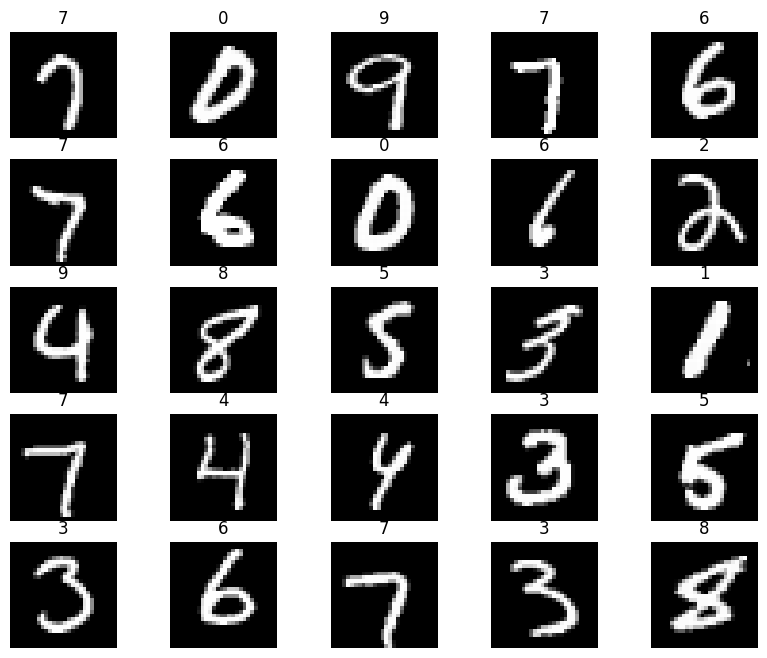

In [5]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 1. (TODO) The CNN Model [15 points]
- Complete the following section to create a CNN model for handwritten digit image recognition.
- The model should consist of convolutional layers, pooling layers and fully connected layers.
- The output should be the categorical distribution over 10 categories (digits 0-9)

In [6]:
class Model(nn.Module):
    """Custom CNN model to recognize the input handwritten digit image"""
    def __init__(self):
        """ Define and instantiate your layers"""
        super(Model, self).__init__()
        # YOUR CODE HERE
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(800, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

        
    def forward(self, x):
        """ 
        Run forward pass on input image X
        
        Args:
            x: torch tensor of input image, 
                with shape of [batch_size * 1 * img_h * img_w]
        
        Return:
            out: torch tensor of predicted categorical distribution  
                on input images, with shape of [batch_size, 10]
         
        """
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(-1, 800)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

### 2. (TODO) The Training Loop [15 points]
- Instantiate the model and optimizer
- Select proper loss function for this task
- Complete the training loop

In [11]:
device = args.device
print('Using device {}'.format(device))
cnn = Model()
cnn = cnn.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=args.lr, momentum=args.momentum)

def train(num_epochs, cnn):
   for epoch in range(num_epochs):
      cnn.train()

      for idx, (img, label) in enumerate(mnist_train_loader):
         img, label = img.to(device), label.to(device)

         optimizer.zero_grad()

         forward = cnn(img)

         loss = loss_func(forward, label)

         loss.backward()
         optimizer.step()

         if idx % args.log_interval == 0:
            print("Epoch: [{}/{}], Train: [[{}/{} ({:.0f}%)], Loss: {:.5f}".format(
                epoch, num_epochs, 
                idx, len(mnist_train_loader), 100. * idx / len(mnist_train_loader),
                loss.item()
            ))

train(args.epochs, cnn)

Using device cpu
Epoch: [0/10], Train: [[0/1200 (0%)], Loss: 2.31018
Epoch: [0/10], Train: [[10/1200 (1%)], Loss: 2.29951
Epoch: [0/10], Train: [[20/1200 (2%)], Loss: 2.26640
Epoch: [0/10], Train: [[30/1200 (2%)], Loss: 2.18762
Epoch: [0/10], Train: [[40/1200 (3%)], Loss: 1.74402
Epoch: [0/10], Train: [[50/1200 (4%)], Loss: 1.25512
Epoch: [0/10], Train: [[60/1200 (5%)], Loss: 1.06221
Epoch: [0/10], Train: [[70/1200 (6%)], Loss: 0.53753
Epoch: [0/10], Train: [[80/1200 (7%)], Loss: 0.41464
Epoch: [0/10], Train: [[90/1200 (8%)], Loss: 0.52422
Epoch: [0/10], Train: [[100/1200 (8%)], Loss: 0.32684
Epoch: [0/10], Train: [[110/1200 (9%)], Loss: 0.31726
Epoch: [0/10], Train: [[120/1200 (10%)], Loss: 0.32287
Epoch: [0/10], Train: [[130/1200 (11%)], Loss: 0.37421
Epoch: [0/10], Train: [[140/1200 (12%)], Loss: 0.26447
Epoch: [0/10], Train: [[150/1200 (12%)], Loss: 0.17060
Epoch: [0/10], Train: [[160/1200 (13%)], Loss: 0.35574
Epoch: [0/10], Train: [[170/1200 (14%)], Loss: 0.17806
Epoch: [0/10], T

KeyboardInterrupt: 

In [10]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in mnist_test_loader:
            test_output = cnn(images.to(device))
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels.to(device)).sum().item()
            total += labels.size(0)
    print('Test Accuracy of the model on the 10000 test images: %.2f %%' % (correct*100.0/total))
test()

Test Accuracy of the model on the 10000 test images: 98.84 %
